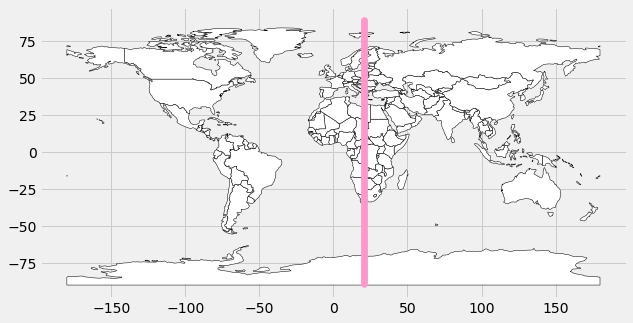

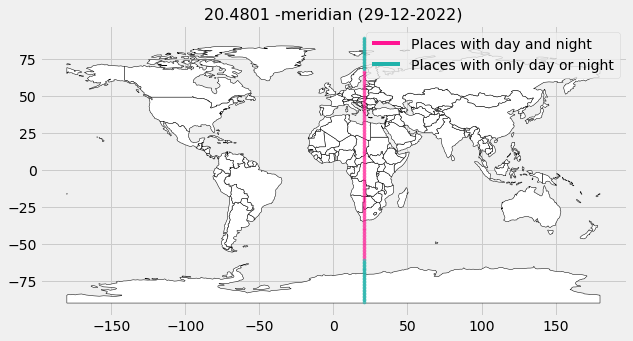

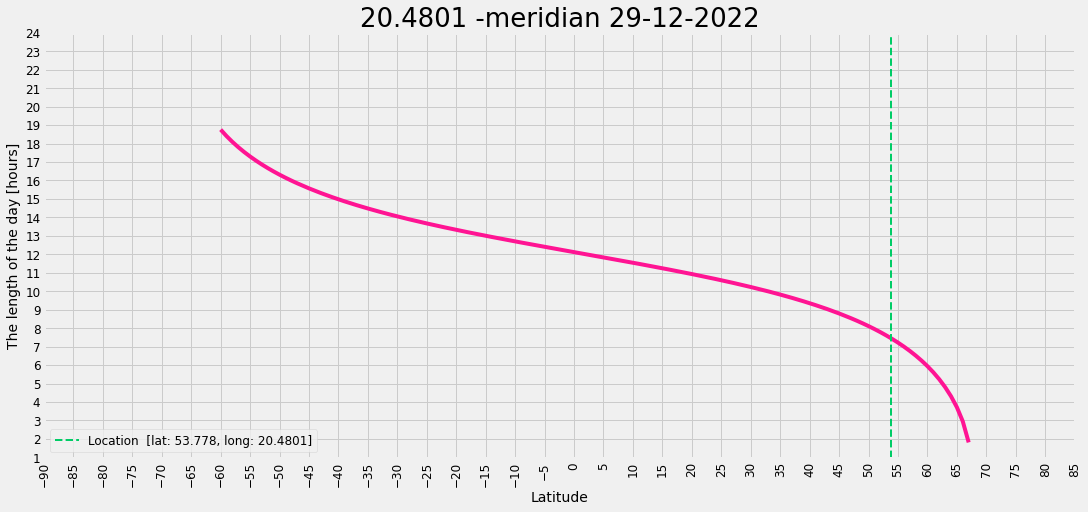

In [1]:
import pandas as pd
import geopandas as gd

from datetime import date

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
plt.style.use("fivethirtyeight")

from astral import LocationInfo
import datetime
from astral.sun import sun
import astral


# in geography and geodesy, a meridian is the locus connecting points of equal longitude
# we will create a list of lattitudes ranging from -89 to 89
lat, long = [53.778 , 20.4801]
year = 2022
month = 12
day = 29

latitudes = list(range(-89, 90, 1))

# with a list of latitudes, we can create a new Pandas dataframe with coordinates along 20.4801 longitude
df = pd.DataFrame({
    'Latitude': latitudes,
    'Longitude': [long for x in range(len(latitudes))]
    })

# converting dataframe to geodataframe
points = gd.GeoDataFrame(
    df, geometry=gd.points_from_xy(df.Longitude, df.Latitude)).set_crs("EPSG:4326")

# generating the map showing meridian
world = gd.read_file('naturalearth_lowres')
ax = world.plot(
    color='white', edgecolor='black', figsize=(10,5))
points.plot(ax=ax, color='#ff99cc')
plt.savefig(f'{long} -meridian ({day}-{month}-{year}).png', bbox_inches='tight')

# obtaining day-length for each point along the meridian on a given day
# output is saved in a dataframe and csv
# time data is given as timedelta and float   -------------------------------------------------------------------
df = points.copy()
df['date'] = datetime.date(year, month, day)

# method returning the length of day as timedelta
# places where the sun is always below or never always above horizon get null values in 'day_timedelta'
def get_length(row):
    lat = row['Latitude']
    long = row['Longitude']
    info = None
    try:
        olsztyn = LocationInfo('Miasto olsztyn', 'region', 'timezone/name', lat, long)
        s = sun(olsztyn.observer, date=datetime.date(year, month, day))
        day_lenght = s["sunset"] - s["sunrise"]
        info = day_lenght
    except ValueError as e:
        # value error when the sun does not set on this latitude or is under the horizon 
        # then the function returns a null value
        info = None
    return info
   

df['day_timedelta'] = df.apply(get_length, axis=1)
df['day_float'] = ((df['day_timedelta'].dt.total_seconds() / 60) /60)

df.to_csv(f'{long} -meridian ({day}-{month}-{year}).csv', encoding='utf-8', index=False) # saving data to CSV  

# generating the map showing places with days and nights or places with only days or nights 
# selecting null values in the 'day_timedelta' column
data = df.copy()
null_values = data[data['day_timedelta'].isnull()]

# dropping null values in the 'day_timedelta' column
data = data.dropna(subset=['day_timedelta'])

legend_elements = [
    Line2D([0], [0], label='Places with day and night', color='deeppink'),
    Line2D([0], [0], label='Places with only day or night', color='lightseagreen')
]
ax = world.plot(
    color='white', edgecolor='black', figsize=(10,5))

data.plot(ax=ax, color='deeppink', alpha=0.4, markersize=10)
null_values.plot(ax=ax, color='lightseagreen', alpha=0.6, markersize=10)

ax.legend(handles=legend_elements)
plt.title(f'{long} -meridian ({day}-{month}-{year})', fontsize=16)
plt.savefig(f'{long} -meridian - {day}-{month}-{year}.png', bbox_inches='tight')


# plotting data
fig, ax = plt.subplots(figsize=(15,7), constrained_layout=True)

legend_elements = [
    Line2D([0], [0], label=f'Location  [lat: {lat}, long: { long}]', color="#00cc66", ls='--', linewidth = 2),

]

ax.plot(df['Latitude'],df['day_float'], color='deeppink')
ax.axvline(lat, color="#00cc66", ls='--', linewidth = 2)

ax.legend(handles=legend_elements, loc='lower left', fontsize=12 )
                          
ax.set_xticks(list(range(-90, 90, 5)))
ax.set_yticks(list(range(1,25, 1)))

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('The length of the day [hours]', fontsize=14)
plt.title(f'{long} -meridian {day}-{month}-{year}', fontsize=26)

plt.savefig(f'{long}-meridian - {day}-{month}-{year} Plot.png', bbox_inches='tight')